In [1]:
library(tidyverse)
library(dplyr)
library(repr)
library(tidymodels)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

# GROUP PROPOSAL: WINE TASTING

## Introduction

- Wine quality highly depends on its composition of various aromatic compounds. By assessing the content of wines such as their sugar content and pH value, we will be able to determine how good the wine is. 
- In this project, we will be using the wine quality dataset obtained from a web URL.
- We want to solve **classification problem** —- what would be the wine’s quality level given its values on the fixed acidity, volatile acidity, and other variables.
-  7 out of the 12 variables are used to predict the **wine quality**, which ranges from 0 to 10, with 10 being the highest quality wine.


## Preliminary exploratory data analysis

**1. Data Reading**

In [2]:
temp <- tempfile()
download_file <- download.file("https://archive.ics.uci.edu/static/public/186/wine+quality.zip", temp)
red_wine <- read.csv2(unz(temp, "winequality-red.csv")) |>
             mutate(type = "Red")
white_wine <- read.csv2(unz(temp, "winequality-white.csv")) |>
              mutate(type ="White")
head(red_wine)
head(white_wine)
unlink(temp)

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,type
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
1,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,Red
2,7.8,0.88,0,2.6,0.098,25,67,0.9968,3.2,0.68,9.8,5,Red
3,7.8,0.76,0.04,2.3,0.092,15,54,0.997,3.26,0.65,9.8,5,Red
4,11.2,0.28,0.56,1.9,0.075,17,60,0.998,3.16,0.58,9.8,6,Red
5,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,Red
6,7.4,0.66,0,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5,Red


,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,type
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
1,7,0.27,0.36,20.7,0.045,45,170,1.001,3,0.45,8.8,6,White
2,6.3,0.3,0.34,1.6,0.049,14,132,0.994,3.3,0.49,9.5,6,White
3,8.1,0.28,0.4,6.9,0.05,30,97,0.9951,3.26,0.44,10.1,6,White
4,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.4,9.9,6,White
5,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.4,9.9,6,White
6,8.1,0.28,0.4,6.9,0.05,30,97,0.9951,3.26,0.44,10.1,6,White


**2. Data Wrangling**

In [3]:
wine_data <- rbind(red_wine, white_wine) |>
             mutate(across(fixed.acidity:alcohol, as.numeric), quality = as_factor(quality),
                   type = as_factor(type))
write_csv(wine_data, "../data/wine_data.csv")
head(wine_data)

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,type
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
1,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,Red
2,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,Red
3,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,Red
4,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,Red
5,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,Red
6,7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5,Red


**3. Data Splitting**

In [4]:
set.seed(2000)
wine_split <- initial_split(wine_data, prop = 0.75, strata = quality)
wine_training <- training(wine_split)
wine_testing <- testing(wine_split)

**4. Summarization**

**a. The number of observations in each red wine/white wine class**

In [5]:
wine_type_number <- wine_training |>
                    group_by(type) |>
                    summarize(Number = n())
wine_type_number

type,Number
<fct>,<int>
Red,1204
White,3667


- We have 4898 observations for White wine and 1599 observations for Red wine.
- There is an imbalance between the types of the wine. 

**b. The number of observations for each quality level.**

In [6]:
quality_number <- wine_training |>
                  group_by(quality) |>
                  summarize(Number = n())
quality_number

quality,Number
<fct>,<int>
3,24
4,166
5,1602
6,2123
7,814
8,138
9,4


- We are missing two classes: 0, 1, 2 and 10.
- This is another class imbalance existed within the class

**c. Mean value of each measurements for different quality type.**

In [7]:
mean_measurements <- wine_training |>
                     group_by(quality) |>
                     summarize(mean_fixed_acidity = mean(fixed.acidity),
                               mean_volatile_acidity = mean(volatile.acidity),
                               mean_citric_acid = mean(citric.acid),
                               mean_residual_sugar = mean(residual.sugar),
                               mean_chlorides = mean(chlorides),
                               mean_free_sufdioxide = mean(free.sulfur.dioxide),
                               mean_tot_sufdioxide = mean(total.sulfur.dioxide),
                               mean_density = mean(density),
                               mean_ph = mean(pH),
                               mean_sulphates = mean(sulphates),
                               mean_alcohol = mean(alcohol))
mean_measurements

quality,mean_fixed_acidity,mean_volatile_acidity,mean_citric_acid,mean_residual_sugar,mean_chlorides,mean_free_sufdioxide,mean_tot_sufdioxide,mean_density,mean_ph,mean_sulphates,mean_alcohol
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,7.691667,0.5508333,0.2691667,4.175000,0.08358333,37.83333,106.0625,0.9957779,3.295833,0.5241667,10.093750
4,7.228313,0.4607229,0.2688554,4.157831,0.06107229,20.98494,104.0753,0.9948237,3.238855,0.4960843,10.174096
5,7.329650,0.3903059,0.3072472,5.791386,0.06469975,30.53620,121.2871,0.9958513,3.209782,0.5262360,9.842258
6,7.177932,0.3154169,0.3211823,5.620066,0.05453132,31.30664,115.3457,0.9946097,3.218031,0.5326189,10.575820
7,7.086978,0.2861548,0.3318182,4.740111,0.04485012,30.39435,108.0682,0.9930359,3.227826,0.5438084,11.414742
8,6.795652,0.2953261,0.3239130,5.638043,0.04083333,35.31884,120.9058,0.9926056,3.222319,0.5135507,11.650000
9,7.000000,0.3050000,0.3700000,2.500000,0.02550000,34.75000,114.0000,0.9900750,3.335000,0.4675000,12.625000


The ranges of the mean are different across different columns hence the variables will need to be scaled 

**d. Missing data - We have no missing data in this dataset.**

**4. Visualization: histogram between quality and other numeric variables**

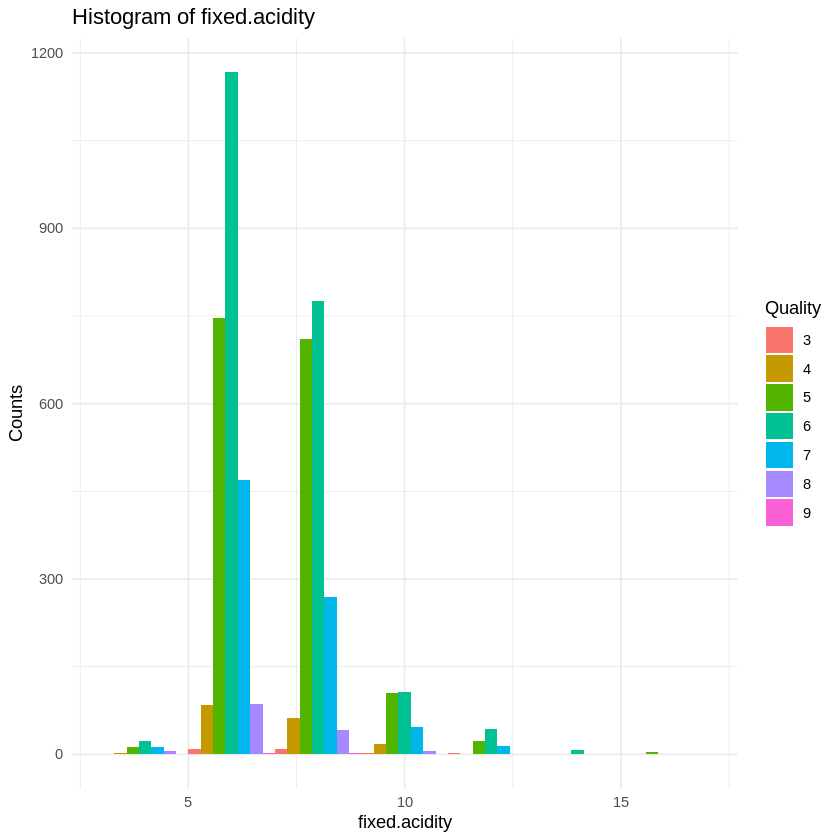

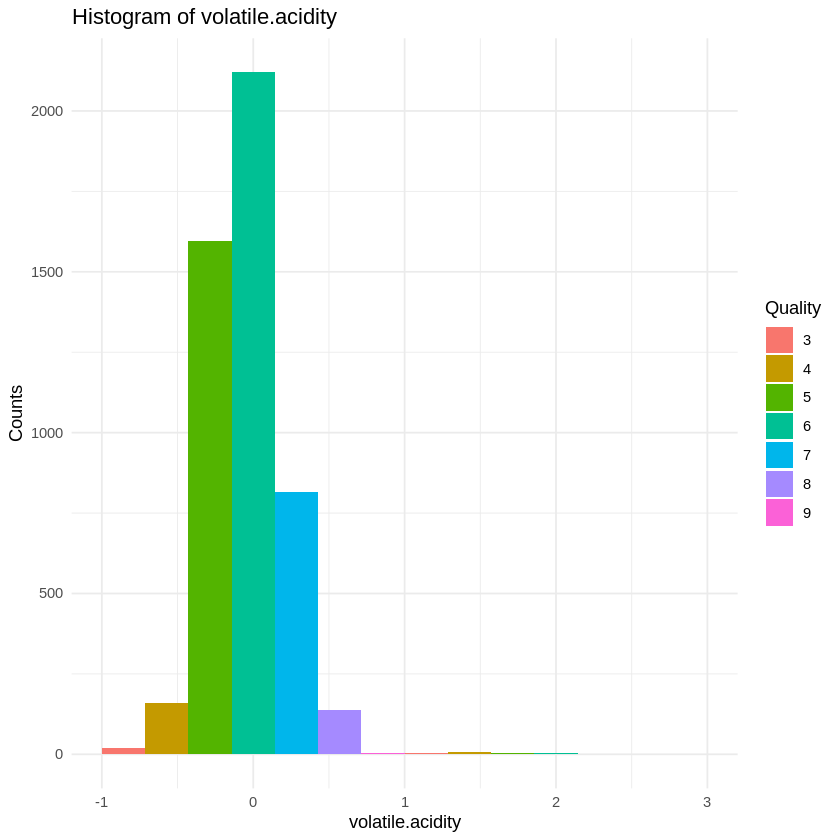

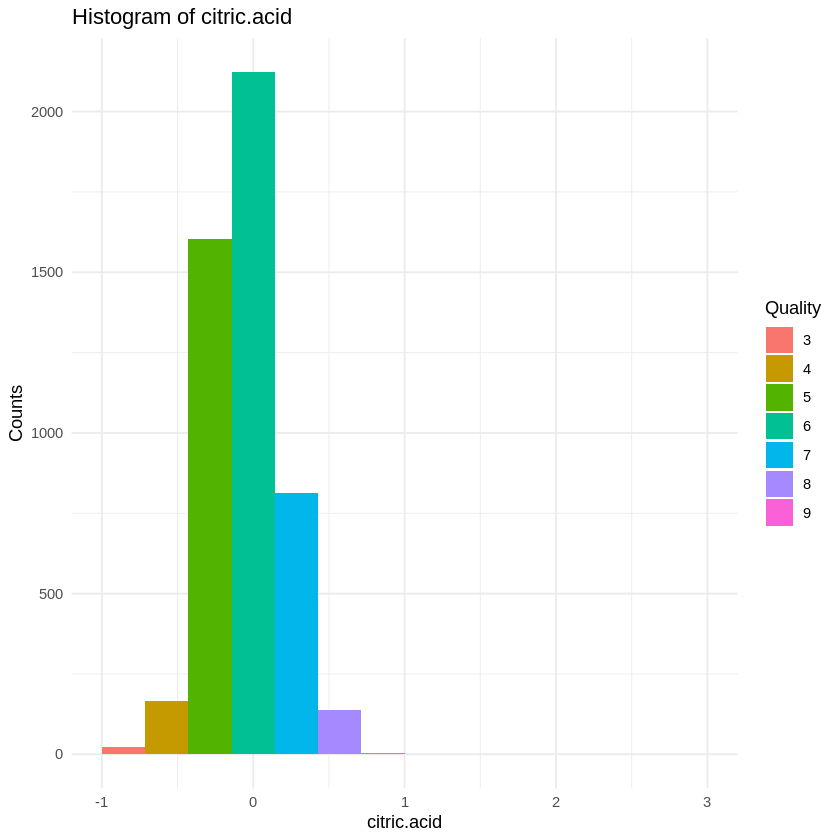

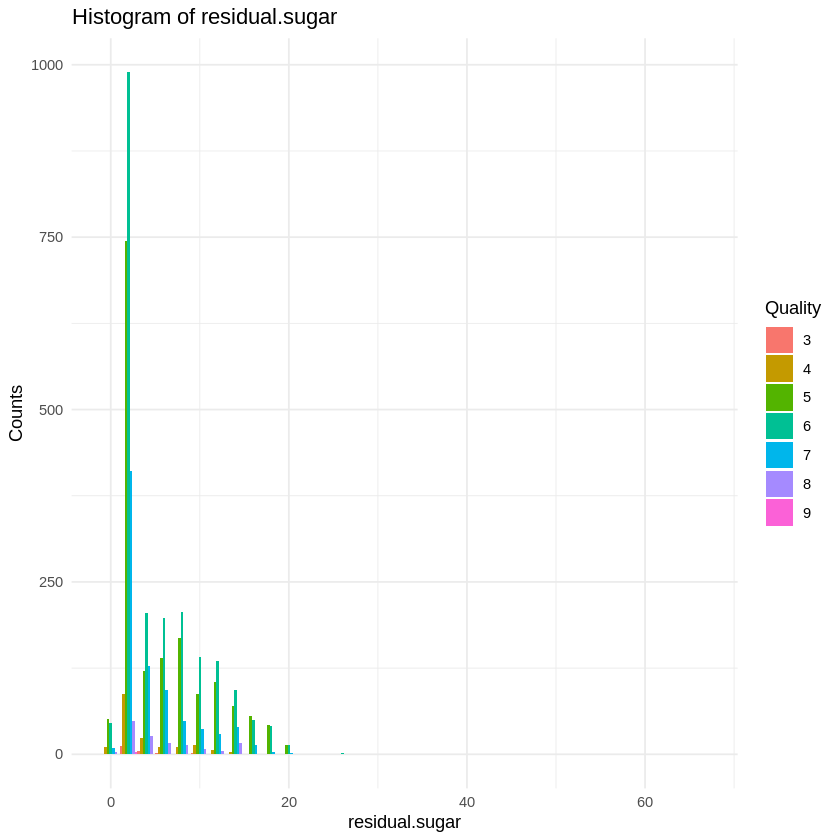

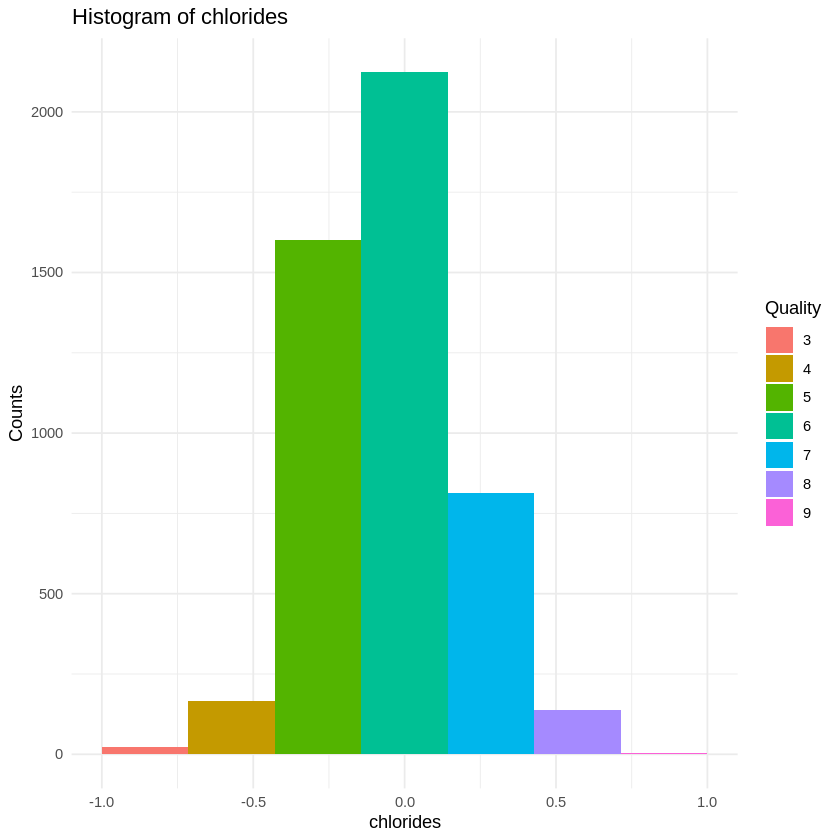

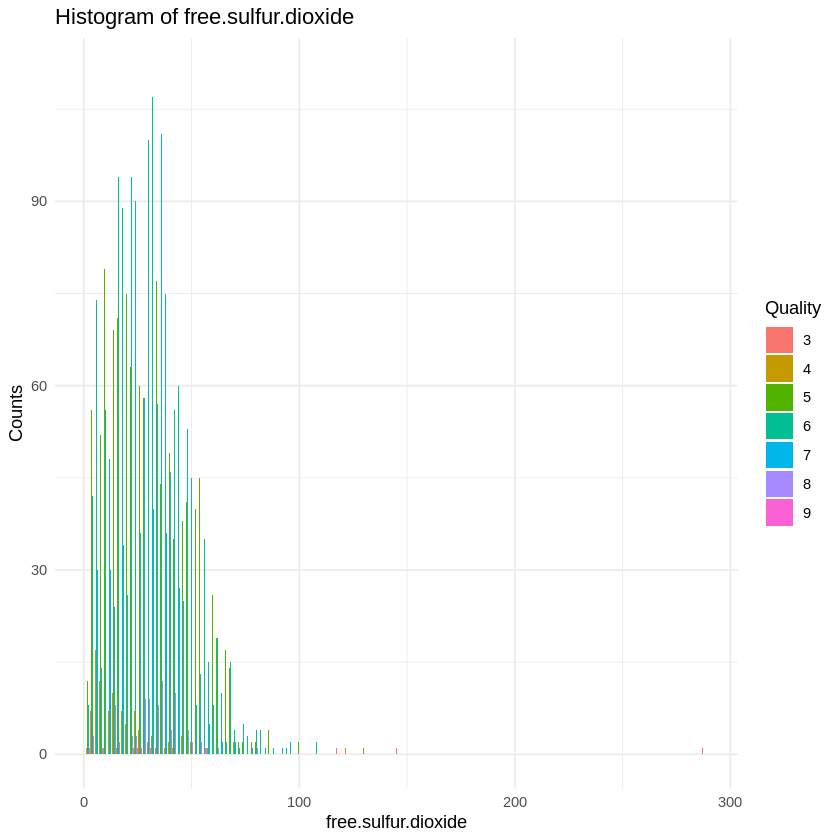

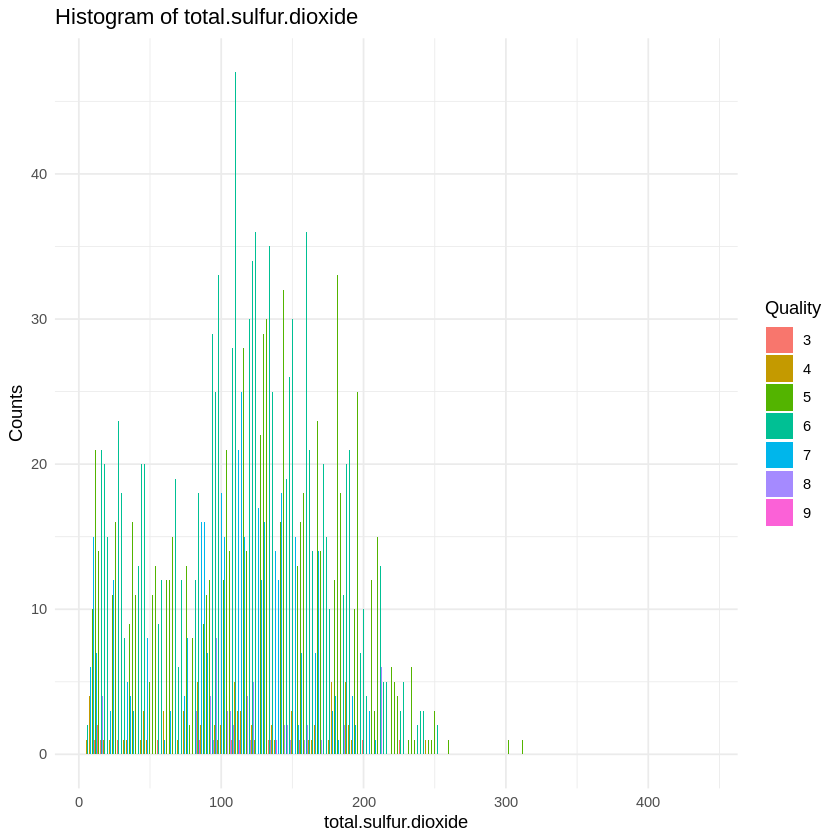

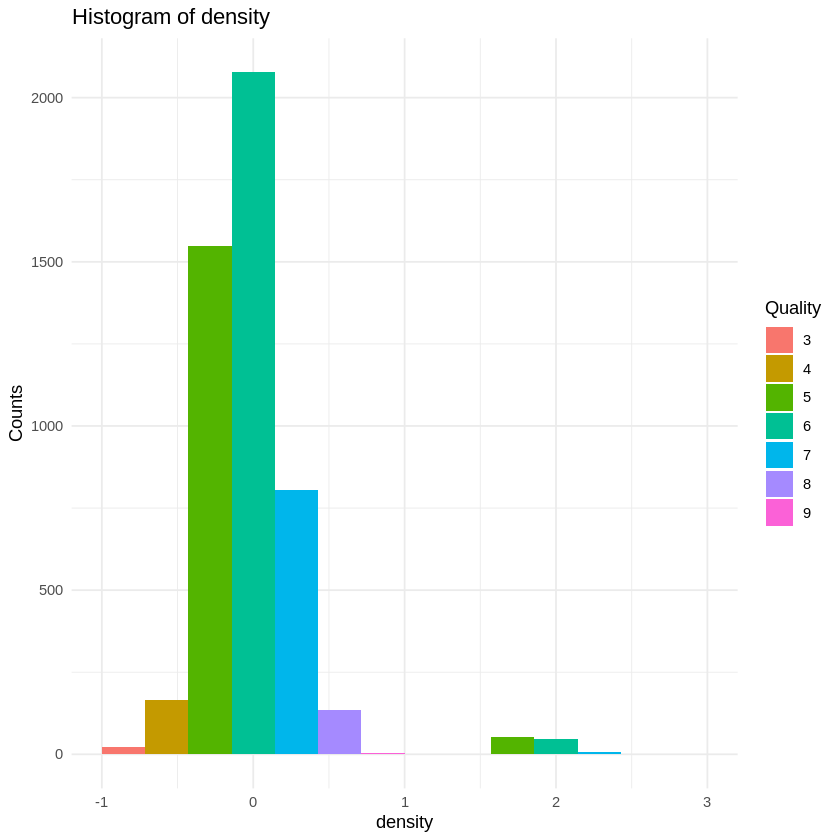

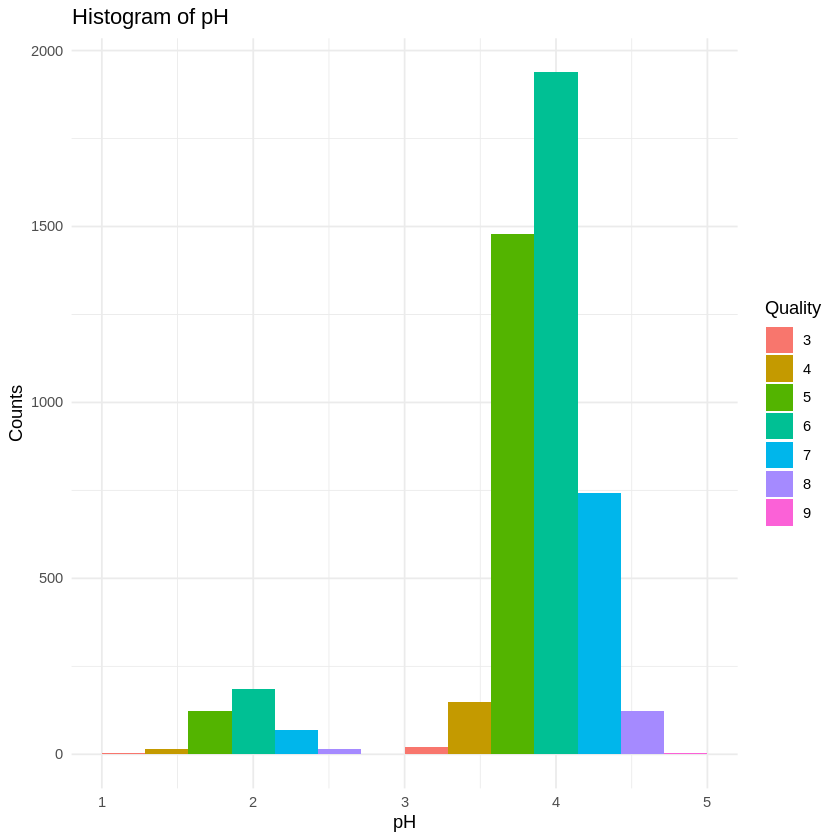

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]

[[9]]

[[10]]

[[11]]


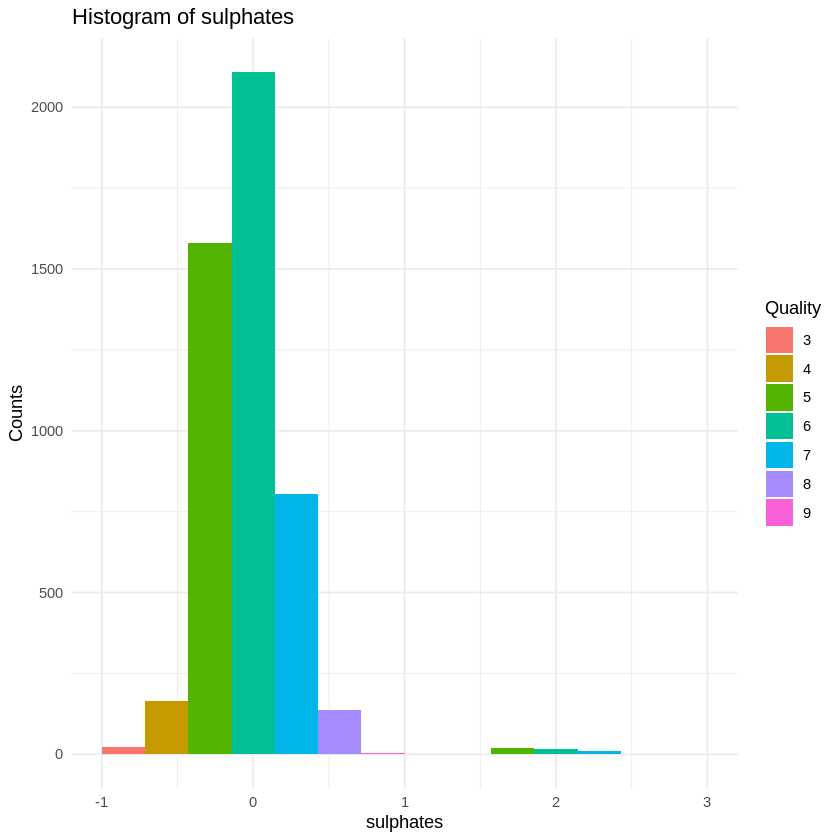

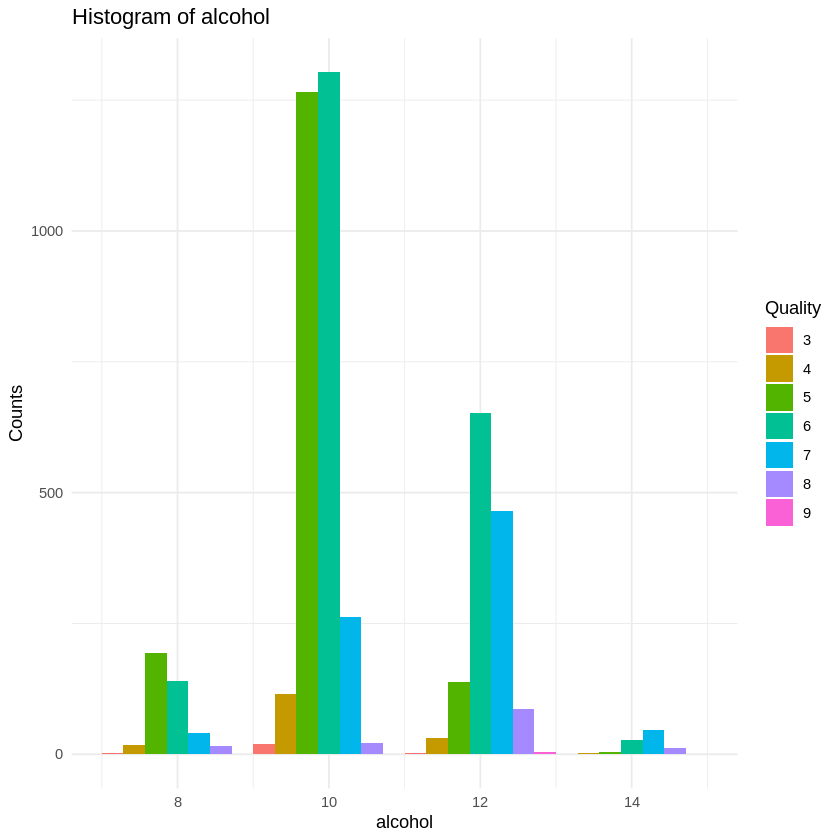

In [8]:
wine_filter <- wine_training |>
               select(-type)

histograms <- lapply(names(wine_filter)[!names(wine_filter) %in% c("quality")], function(col) {
  ggplot(wine_filter, aes(x = !!sym(col), fill = quality)) +
    geom_histogram(position = "dodge", bins = 100, binwidth = 2) +
    labs(title = paste("Histogram of", col), x = col, y = "Counts", fill = "Quality") +
    theme_minimal()
})

histograms

- Most variables have a linear negative correlation to quality
- free.sulfur.dioxide and total.sulfur. dioxide seems to have no correlation with quality as the categories' bins are layered in the histogram.
- alcohol and residual.sugar have a non-linear relationship with quality

## Regression Trainning & Evaluation

### The multivariable Linear regression Model

In [9]:
set.seed(1)
wine_data_reg <- wine_data |>
    mutate(quality = as.numeric(quality)) |>
    select(fixed.acidity, volatile.acidity, citric.acid, chlorides, density, pH, sulphates, quality)
head(wine_data_reg)

recipe <- recipe(quality ~ .,
                 data = wine_data_reg) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) |>
  prep()
recipe

wine_scaled_reg <- bake(recipe, wine_data_reg)
wine_scaled_reg

wine_reg_split <- initial_split(wine_scaled_reg, prop = 0.75, strata = quality)
wine_reg_training <- training(wine_reg_split)
wine_reg_testing <- testing(wine_reg_split)

lm_recipe <- recipe(quality ~ .,
                    data = wine_reg_training)
lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

lm_fit <- workflow() |>
  add_recipe(lm_recipe) |>
  add_model(lm_spec) |>
  fit(data = wine_reg_training)

lm_fit

lm_test_results <- lm_fit |>
  predict(wine_reg_testing) |>
  bind_cols(wine_reg_testing) |>
  metrics(truth = quality, estimate = .pred)

lm_test_results

lm_coeffs <- lm_fit |>
             extract_fit_parsnip() |>
             tidy()
lm_coeffs

,fixed.acidity,volatile.acidity,citric.acid,chlorides,density,pH,sulphates,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,7.4,0.70,0.00,0.076,0.9978,3.51,0.56,3
2,7.8,0.88,0.00,0.098,0.9968,3.20,0.68,3
3,7.8,0.76,0.04,0.092,0.9970,3.26,0.65,3
4,11.2,0.28,0.56,0.075,0.9980,3.16,0.58,4
5,7.4,0.70,0.00,0.076,0.9978,3.51,0.56,3
6,7.4,0.66,0.00,0.075,0.9978,3.51,0.56,3




── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 7



── Training information 

Training data contained 6497 data points and no incomplete rows.



── Operations 

• Scaling for: fixed.acidity, volatile.acidity, citric.acid, ... | Trained

• Centering for: fixed.acidity, volatile.acidity, citric.acid, ... | Trained



fixed.acidity,volatile.acidity,citric.acid,chlorides,density,pH,sulphates,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.14246230,2.1886645,-2.19266376,0.5699140,1.03491316,1.8129500,0.193081910,3
0.45100101,3.2819823,-2.19266376,1.1978825,0.70143232,-0.1150642,0.999501691,3
0.45100101,2.5531038,-1.91740510,1.0266184,0.76812849,0.2580999,0.797896746,3
3.07358005,-0.3624106,1.66095741,0.5413699,1.10160933,-0.3638402,0.327485207,4
0.14246230,2.1886645,-2.19266376,0.5699140,1.03491316,1.8129500,0.193081910,3
0.14246230,1.9457049,-2.19266376,0.5413699,1.03491316,1.8129500,0.193081910,3
0.52813569,1.5812656,-1.77977577,0.3701058,0.56803999,0.5068759,-0.478934574,3
0.06532762,1.8849651,-2.19266376,0.2559297,-0.03222553,1.0666219,-0.411732925,5
0.45100101,1.4597859,-2.05503443,0.4842819,0.70143232,0.8800399,0.260283559,5


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
     (Intercept)     fixed.acidity  volatile.acidity       citric.acid  
         3.81502           0.08707          -0.18997           0.01716  
       chlorides           density                pH         sulphates  
        -0.09946          -0.25886           0.07754           0.13857  


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.8029350
rsq,standard,0.1667109
mae,standard,0.6274215


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),3.81501672,0.01134216,336.357069,0.000000e+00
fixed.acidity,0.08707008,0.01508388,5.772391,8.300219e-09
volatile.acidity,-0.18996941,0.01483134,-12.808650,5.769663e-37
citric.acid,0.01716328,0.01396913,1.228658,2.192596e-01
chlorides,-0.09945725,0.01369697,-7.261260,4.443233e-13
density,-0.25886222,0.01328623,-19.483504,1.800172e-81
pH,0.07753980,0.01312903,5.905982,3.743811e-09
sulphates,0.13857399,0.01300352,10.656649,3.154270e-26


The mathematical expression to describe this linear regression model is:
$quality = 3.81501672 + 0.08707008 \cdot (fixed.acidity) - 0.18996941 \cdot (volatile.acidity) + 0.01716328 \cdot (citric.acid) - 0.09945725 \cdot (chlorides) - 0.25886222 \cdot (density) + 0.07753980 \cdot (pH) + 0.13857399 \cdot (sulphates)$

## Methods

- After data reading and wrangling, we used all 12 variables for preliminary data summarization and visualization. We then compared the number of observations in each red/ white wine class, the number of observations in each quality level for red and white wine respectively, and the mean value of each feature for each quality level. 

- Multi-histogram is used to visualize the relationship between each variable and the wine quality, each with one predictor on the x axis, counts on the y axis, and color indicating the different quality levels. If each quality level tends to show up on a certain value of the x axis, we can conclude that there is linear correlation between the wine quality and that predictor. Otherwise, there is no correlation or non-linear correlation. 

- **We will only use 7 numeric variables excluding type total.sulfur.dioxide, free.sulfur.dioxide, residual sugar and alcohol** 

## Expected outcomes and significance

- Due to class imbalance in the categories of the target column (quality): some of the categories are missing. We expect the model will be less precise for the level from 0 to 2 and the level 10.
- However, we hope the model will be able to predict correctly the quality from 3 - 8

- These findings will allow a more efficient and more systematic wine quality assessment as we will be able assess the quality of the wines not only by its age or individual tastes, but also the actual content in the wine itself.
-  The findings can also lead to further discoveries such as how different environments in which the grapes grew in would affect the quality of the wines, in which they can be used to optimize the wine development.
